In [1]:
import numpy as np
from random import shuffle
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)

その分野の良いものを見つけたければ、その分野の専門家・マニア・オタクに聞くべきだ、素人がどんなに多くの票を入れたからと言って、それが良いものだとは思わない

という思想の下、玄人優先のランキングアルゴリズムを作る。誰の票を重く見るかを示す変数の決め方を変えれば、カスタマイズ可能になることが望ましい。

与えられる情報は、
①ノミネート数
②タイトルのID
③だれがどのタイトルに何票投票したか
④投票者各位がどのタイトルの中から投票タイトルを選択したか

となる。

In [2]:
#db = pd.read_csv("data.csv")

In [3]:
N = 100 #   ノミネートタイトル数
M = 10**4   #   投票者数
L = 30  #   投票者一人当たりのタイトル経験数スケール(目安)
K = 10  #   一人当たりの投票権利数
LOGSCALE_RANGE = 5

In [4]:
#   データ生成のセル
def make_nominated_title_db(N, value_vector=None, popularity_vector=None):
    col = ["id", "popularity", "experienced counter", "value", "simple vote", "simple vote ranking", "corrected vote", "corrected vote ranking",
            "simple vote rate", "simple vote rate ranking", "professional vote point", "professional ranking", "professional vote point 2", "professional ranking 2"]
    info = [[None for _ in range(len(col))] for _ in range(N)]
    nominated_title_db = pd.DataFrame(info, columns=col)
    nominated_title_db["id"] = nominated_title_db.index
    nominated_title_db["popularity"] = popularity_vector
    nominated_title_db["value"] = value_vector
    nominated_title_db["experienced counter"] = 0
    nominated_title_db["simple vote"] = 0
    nominated_title_db["corrected vote"] = 0
    nominated_title_db["professional vote point"] = 0
    nominated_title_db["professional vote point 2"] = 0
    nominated_title_db["corrected vote"] = 0

    return nominated_title_db

def make_data(N, M, L, K, nominated_title_db):
    col = ["name", "experienced title list", "number of experienced title", "voted title info list", "poll", "waight"]
    info = [[None for _ in range(len(col))] for _ in range(M)]
    voter_db = pd.DataFrame(info, columns=col)
    voter_db["name"] = voter_db.index

    j1 = col.index("experienced title list")
    j2 = col.index("number of experienced title")
    waight_col_j = col.index("waight")
    voted_title_col_j = col.index("voted title info list")
    poll_col_j = col.index("poll")

    popularity_arr, value_arr = None, None
    if nominated_title_db.at[0, "popularity"] is not None:
        popularity_arr = np.array(list(nominated_title_db.loc[:,"popularity"].values))
    if nominated_title_db.at[0, "value"] is not None:
        value_arr = np.array(list(nominated_title_db.loc[:,"value"].values))

    for i in range(len(voter_db)):
        number_of_experienced_title = N
        for _ in range(int(np.log2(N/L))):
            number_of_experienced_title = np.random.randint(1,number_of_experienced_title+1)
        t = list(set(np.random.choice([i for i in range(N)], number_of_experienced_title, p=popularity_arr/np.sum(popularity_arr))))
        shuffle(t)
        voter_db.iat[i, j1] = t
        voter_db.iat[i, j2] = len(t)
        voter_db.iat[i, waight_col_j] = len(t) #   ここはどうする？

        u = t[:np.random.randint(1, len(t)+1)]
        lst = []
        kh = np.random.randint(1, K+1, len(u))
        M = 0
        for h in range(len(u)):
            kh[h] += int(K*value_arr[u[h]])
            M += kh[h]
        while np.sum(kh) > K:
            h = np.random.randint(0,len(kh))
            if kh[h] > 0:
                kh[h] -= 1
                M -= 1
        for h, voted_point in enumerate(kh):
            if voted_point > 0:
                lst.append((u[h], voted_point))
        voter_db.iat[i, voted_title_col_j] = lst
        voter_db.iat[i, poll_col_j] = M
    
    voter_db.iloc[:,waight_col_j] *= K/voter_db.iloc[:,poll_col_j]  #   票数が少なかったら重み補正　ここはないほうが良い場合もあるかな
    voter_db.iloc[:,waight_col_j] /= sum(voter_db.iloc[:,waight_col_j])
    return voter_db


popularity_vector = np.exp(-LOGSCALE_RANGE*np.arange(N)/N)
value_vector = np.random.randn(N) + (N - np.arange(N))/N
value_vector += -np.min(value_vector)
value_vector /= np.max(value_vector)
nominated_title_db = make_nominated_title_db(N, value_vector=value_vector, popularity_vector=popularity_vector)

voter_db = make_data(N, M, L, K, nominated_title_db)
voter_db

,name,experienced title list,number of experienced title,voted title info list,poll,waight
0,0,"[0, 8, 74, 3, 5, 17, 9, 15, 44, 36, 41, 25, 14...",21,"[(0, 1), (5, 4), (44, 1), (36, 4)]",10,0.000074
1,1,"[0, 33, 29, 3, 6, 13, 53, 5, 23, 43, 18, 37, 1...",36,"[(0, 2), (5, 1), (23, 7)]",10,0.000128
2,2,"[28, 84, 17, 9, 12, 0, 85, 3, 42, 20, 15, 32, ...",41,"[(84, 4), (12, 1), (0, 1), (5, 4)]",10,0.000145
3,3,"[38, 34, 42, 43, 45, 12, 0, 15, 31, 14, 32, 7,...",33,"[(34, 4), (43, 3), (12, 2), (0, 1)]",10,0.000117
4,4,"[22, 19, 54, 9, 13, 20, 0, 6, 11, 8, 5, 32, 44...",25,"[(13, 3), (11, 5), (32, 2)]",10,0.000089
...,...,...,...,...,...,...
9995,9995,"[3, 26, 32, 27, 23, 18, 1, 16, 13, 59, 14]",11,"[(3, 3), (26, 7)]",10,0.000039
9996,9996,"[6, 26, 16, 2, 9, 76, 28, 33, 4, 17, 23, 14, 3...",33,"[(62, 4), (7, 1), (18, 3), (8, 2)]",10,0.000117
9997,9997,"[66, 46, 2, 40, 30, 11, 33, 48, 34, 13, 19, 65...",44,"[(46, 1), (40, 3), (34, 6)]",10,0.000156
9998,9998,"[27, 0, 6, 13, 19, 33, 57, 7, 69, 23, 54, 2, 5...",33,"[(27, 6), (19, 2), (33, 2)]",10,0.000117


In [5]:
def count_experiment(voter_db, nominated_title_db):
    j = list(voter_db.columns).index("experienced title list")
    k = list(nominated_title_db.columns).index("experienced counter")
    for i in range(len(voter_db)):
        for title_id in voter_db.iat[i, j]:
            nominated_title_db.iat[title_id, k] += 1
    nominated_title_db.sort_values("experienced counter", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    return nominated_title_db
nominated_title_db = count_experiment(voter_db, nominated_title_db)

In [6]:
def make_pointVector(N):
    point_vector = np.zeros(N)

    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    waight_col_j = list(voter_db.columns).index("waight")

    for i in range(len(voter_db)):
        for title_id, voted_point in voter_db.iat[i,voted_title_col_j]:
            point_vector[title_id] += voted_point * voter_db.iat[i,waight_col_j]
    
    return point_vector
point_vector = make_pointVector(N)

In [7]:
def input_simple_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M):
    simple_vote_col_j = list(nominated_title_db.columns).index("simple vote")
    simple_vote_ranking_col_j = list(nominated_title_db.columns).index("simple vote ranking")
    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    nominated_title_db.sort_values("id", inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    for i in range(M):
        for title_id, vote_number in voter_db.iat[i, voted_title_col_j]:
            nominated_title_db.iat[title_id, simple_vote_col_j] += vote_number

    nominated_title_db.sort_values("simple vote", ascending=False, inplace=True)
    nominated_title_db["simple vote ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, simple_vote_col_j] == nominated_title_db.iat[i+1, simple_vote_col_j]:
            nominated_title_db.iat[i+1, simple_vote_ranking_col_j] = nominated_title_db.iat[i, simple_vote_ranking_col_j]
    return nominated_title_db
nominated_title_db = input_simple_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M)
nominated_title_db.reset_index(drop=True, inplace=True)

In [8]:
def make_simple_vote_rate_ranking(nominated_title_db, N):
    rate_j = list(nominated_title_db.columns).index("simple vote rate")
    ranking_j = list(nominated_title_db.columns).index("simple vote rate ranking")
    
    nominated_title_db["simple vote rate"] = nominated_title_db["simple vote"] / nominated_title_db["experienced counter"]
    nominated_title_db.fillna(0, inplace=True)
    nominated_title_db.sort_values("simple vote rate", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)

    nominated_title_db["simple vote rate ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, rate_j] == nominated_title_db.iat[i+1, rate_j]:
            nominated_title_db.iat[i+1, ranking_j] = nominated_title_db.iat[i, ranking_j]
        
    return nominated_title_db
make_simple_vote_rate_ranking(nominated_title_db, N)

,id,popularity,experienced counter,value,simple vote,simple vote ranking,corrected vote,corrected vote ranking,simple vote rate,simple vote rate ranking,professional vote point,professional ranking,professional vote point 2,professional ranking 2
0,21,0.349938,5287,1.000000,6307,1,0,0,1.192926,1,0,0,0,0
1,19,0.386741,5647,0.970018,5298,2,0,0,0.938197,2,0,0,0,0
2,12,0.548812,6646,0.871971,4897,3,0,0,0.736834,3,0,0,0,0
3,5,0.778801,7510,0.709433,4511,4,0,0,0.600666,4,0,0,0,0
4,20,0.367879,5426,0.797890,3202,8,0,0,0.590122,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,91,0.010567,241,0.131302,18,97,0,0,0.074689,96,0,0,0,0
96,61,0.047359,1131,0.081664,75,80,0,0,0.066313,97,0,0,0,0
97,97,0.007828,189,0.395730,12,99,0,0,0.063492,98,0,0,0,0
98,98,0.007447,189,0.000000,9,100,0,0,0.047619,99,0,0,0,0


In [9]:
def input_corrected_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M):
    corrected_vote_col_j = list(nominated_title_db.columns).index("corrected vote")
    corrected_vote_ranking_col_j = list(nominated_title_db.columns).index("corrected vote ranking")
    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    waight_col_j = list(voter_db.columns).index("waight")
    nominated_title_db.sort_values("id", inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    for i in range(M):
        for title_id, vote_number in voter_db.iat[i, voted_title_col_j]:
            nominated_title_db.iat[title_id, corrected_vote_col_j] += vote_number*voter_db.iat[i, waight_col_j]

    nominated_title_db.sort_values("corrected vote", ascending=False, inplace=True)
    nominated_title_db["corrected vote ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, corrected_vote_col_j] == nominated_title_db.iat[i+1, corrected_vote_col_j]:
            nominated_title_db.iat[i+1, corrected_vote_ranking_col_j] = nominated_title_db.iat[i, corrected_vote_ranking_col_j]
    return nominated_title_db
nominated_title_db = input_corrected_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M)
nominated_title_db.reset_index(drop=True, inplace=True)

In [10]:
def make_pointvector(N):
    point_vector = np.zeros(N)

    experienced_counter = np.zeros(N)
    voted_counter = np.zeros(N)

    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    experienced_title_col_j = list(voter_db.columns).index("experienced title list")
    waight_col_j = list(voter_db.columns).index("waight")

    for i in range(len(voter_db)):
        max_point = 0
        voted_title_id_set = set()
        for pivot_title_id, pivot_voted_point in voter_db.iat[i,voted_title_col_j]:
            voted_title_id_set.add(pivot_title_id)
            voted_counter[pivot_title_id] += pivot_voted_point
            if max_point < pivot_voted_point * voter_db.iat[i,waight_col_j]:
                max_point = pivot_voted_point * voter_db.iat[i,waight_col_j]
            for title_id, voted_point in voter_db.iat[i,voted_title_col_j]:
                point_vector[pivot_title_id] -= voted_point * voter_db.iat[i,waight_col_j]    #   投票された体験同氏の、最大値から見た相対評価
        for experienced_title_id in voter_db.iat[i,experienced_title_col_j]:
            if experienced_title_id in voted_title_id_set:
                point_vector[experienced_title_id] += max_point * (len(voter_db.iat[i,voted_title_col_j]) - 1)    #   投票されたこと自体を評価してベースラインを引き上げ0以上に
            experienced_counter[experienced_title_id] += len(voter_db.iat[i,experienced_title_col_j]) - 1
    
    point_vector -= np.min(point_vector)   #   投票の偏りは指数分布なので、point_vectorも指数分布に近いはず
    point_vector *= len(point_vector) / np.sum(point_vector)
    point_vector = np.log(point_vector + 1)
    satisfaction = voted_counter/(experienced_counter+1)    #   sum(satisfaction) ∝ MK/N    投票の偏りは指数分布なので、satisfactionも指数分布に近いはず
    satisfaction -= np.min(satisfaction)
    satisfaction *= len(satisfaction) / np.sum(satisfaction)
    point_vector_2 = point_vector + np.log(np.exp(-LOGSCALE_RANGE)*K*M/N + 1) * np.log(satisfaction + 1)  #   経験数当たりの被投票数の単調増加関数をかけ、"満足度"を評価に加える
    point_vector_2 *= len(point_vector_2) / np.sum(np.abs(point_vector_2))
    
    return point_vector, point_vector_2
point_vector, point_vector_2 = make_pointvector(N)

In [11]:
def input_professional_to_nominated_title_db(nominated_title_db, point_vector, point_vector_2, N):
    point_j = list(nominated_title_db.columns).index("professional vote point")
    ranking_j = list(nominated_title_db.columns).index("professional ranking")
    point2_j = list(nominated_title_db.columns).index("professional vote point 2")
    ranking2_j = list(nominated_title_db.columns).index("professional ranking 2")

    nominated_title_db.sort_values("id", ascending=True, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db["professional vote point"] = point_vector
    nominated_title_db["professional vote point 2"] = point_vector_2
    nominated_title_db.sort_values("professional vote point", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db.iloc[:, ranking_j] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, point_j] == nominated_title_db.iat[i+1, point_j]:
            nominated_title_db.iat[i+1, ranking_j] = nominated_title_db.iat[i, ranking_j]
    nominated_title_db.sort_values("professional vote point 2", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db.iloc[:, ranking2_j] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, point2_j] == nominated_title_db.iat[i+1, point2_j]:
            nominated_title_db.iat[i+1, ranking2_j] = nominated_title_db.iat[i, ranking2_j]
    
    return nominated_title_db
nominated_title_db = input_professional_to_nominated_title_db(nominated_title_db, point_vector, point_vector_2, N)
nominated_title_db.reset_index(drop=True, inplace=True)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,corrected vote,corrected vote ranking,simple vote rate,simple vote rate ranking,professional vote point,professional ranking,professional vote point 2,professional ranking 2
0,21,0.349938,5287,1.000000,6307,1,0.681431,1,1.192926,1,1.666478,2,2.889449,1
1,19,0.386741,5647,0.970018,5298,2,0.563626,2,0.938197,2,1.570981,5,2.617815,2
2,12,0.548812,6646,0.871971,4897,3,0.506003,3,0.736834,3,1.677948,1,2.469495,3
3,5,0.778801,7510,0.709433,4511,4,0.439080,4,0.600666,4,1.611288,3,2.274002,4
4,20,0.367879,5426,0.797890,3202,8,0.327399,7,0.590122,5,1.399929,10,2.112532,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,61,0.047359,1131,0.081664,75,80,0.008807,77,0.066313,97,0.071752,84,0.130460,96
96,91,0.010567,241,0.131302,18,97,0.001963,98,0.074689,96,0.007369,98,0.128811,97
97,97,0.007828,189,0.395730,12,99,0.001287,99,0.063492,98,0.008874,97,0.079596,98
98,84,0.014996,365,0.284042,17,98,0.002226,97,0.046575,100,0.012626,96,0.006853,99


In [12]:
pd.set_option('display.max_rows', None)

def add_value_ranking(nominated_title_db, N):
    nominated_title_db["value ranking"] = 0
    nominated_title_db.sort_values("value", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db.loc[:, "value ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, -1] == nominated_title_db.iat[i+1, -1]:
            nominated_title_db.iat[i+1, -1] = nominated_title_db.iat[i, -1]
    return nominated_title_db
add_value_ranking(nominated_title_db, N)
nominated_title_db.sort_values("simple vote rate ranking")

,id,popularity,experienced counter,value,simple vote,simple vote ranking,corrected vote,corrected vote ranking,simple vote rate,simple vote rate ranking,professional vote point,professional ranking,professional vote point 2,professional ranking 2,value ranking
0,21,0.349938,5287,1.000000,6307,1,0.681431,1,1.192926,1,1.666478,2,2.889449,1,1
1,19,0.386741,5647,0.970018,5298,2,0.563626,2,0.938197,2,1.570981,5,2.617815,2,2
2,12,0.548812,6646,0.871971,4897,3,0.506003,3,0.736834,3,1.677948,1,2.469495,3,3
7,5,0.778801,7510,0.709433,4511,4,0.439080,4,0.600666,4,1.611288,3,2.274002,4,8
3,20,0.367879,5426,0.797890,3202,8,0.327399,7,0.590122,5,1.399929,10,2.112532,5,4
6,39,0.142274,2837,0.732167,1572,22,0.173798,21,0.554106,6,0.962307,22,1.786736,13,7
5,63,0.042852,1030,0.738605,556,43,0.062727,42,0.539806,7,0.521316,44,1.506347,22,6
19,15,0.472367,6280,0.606472,3093,9,0.321760,9,0.492516,8,1.386700,12,1.965504,9,20
20,9,0.637628,7069,0.601924,3424,6,0.335972,6,0.484368,9,1.414301,8,1.980721,8,21
8,0,1.000000,8069,0.690016,3898,5,0.355921,5,0.483083,10,1.579410,4,2.090500,6,9


In [13]:
pd.set_option('display.max_rows', None)

ranking_db = nominated_title_db[["id", "popularity", "value", "value ranking", "simple vote ranking", "corrected vote ranking", "simple vote rate ranking", "professional ranking", "professional ranking 2"]]
value_top10_ranking_db = ranking_db.sort_values("value ranking").iloc[:10,:]
corrected_vote_top10_ranking_db = ranking_db.sort_values("corrected vote ranking").iloc[:10,:]
simple_vote_rate_top10_ranking_db = ranking_db.sort_values("simple vote rate ranking").iloc[:10,:]
professional_top10_ranking_db = ranking_db.sort_values("professional ranking").iloc[:10,:]
professional_2_top10_ranking_db = ranking_db.sort_values("professional ranking 2").iloc[:10,:]
ranking_db.sort_values("professional ranking 2", inplace=True)
ranking_db

C:\Users\honka\AppData\Local\Temp\ipykernel_11744\4250251957.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking_db.sort_values("professional ranking 2", inplace=True)


,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking,professional ranking 2
0,21,0.349938,1.000000,1,1,1,1,2,1
1,19,0.386741,0.970018,2,2,2,2,5,2
2,12,0.548812,0.871971,3,3,3,3,1,3
7,5,0.778801,0.709433,8,4,4,4,3,4
3,20,0.367879,0.797890,4,8,7,5,10,5
8,0,1.000000,0.690016,9,5,5,10,4,6
11,10,0.606531,0.645536,12,7,8,12,6,7
20,9,0.637628,0.601924,21,6,6,9,8,8
19,15,0.472367,0.606472,20,9,9,8,12,9
12,13,0.522046,0.642793,13,11,10,15,9,10


In [14]:
value_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking,professional ranking 2
0,21,0.349938,1.000000,1,1,1,1,2,1
1,19,0.386741,0.970018,2,2,2,2,5,2
2,12,0.548812,0.871971,3,3,3,3,1,3
3,20,0.367879,0.797890,4,8,7,5,10,5
4,47,0.095369,0.755232,5,32,29,13,28,21
5,63,0.042852,0.738605,6,43,42,7,44,22
6,39,0.142274,0.732167,7,22,21,6,22,13
7,5,0.778801,0.709433,8,4,4,4,3,4
8,0,1.000000,0.690016,9,5,5,10,4,6
9,23,0.316637,0.680997,10,16,16,17,17,15


In [15]:
corrected_vote_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking,professional ranking 2
0,21,0.349938,1.000000,1,1,1,1,2,1
1,19,0.386741,0.970018,2,2,2,2,5,2
2,12,0.548812,0.871971,3,3,3,3,1,3
7,5,0.778801,0.709433,8,4,4,4,3,4
8,0,1.000000,0.690016,9,5,5,10,4,6
20,9,0.637628,0.601924,21,6,6,9,8,8
3,20,0.367879,0.797890,4,8,7,5,10,5
11,10,0.606531,0.645536,12,7,8,12,6,7
19,15,0.472367,0.606472,20,9,9,8,12,9
12,13,0.522046,0.642793,13,11,10,15,9,10


In [16]:
simple_vote_rate_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking,professional ranking 2
0,21,0.349938,1.000000,1,1,1,1,2,1
1,19,0.386741,0.970018,2,2,2,2,5,2
2,12,0.548812,0.871971,3,3,3,3,1,3
7,5,0.778801,0.709433,8,4,4,4,3,4
3,20,0.367879,0.797890,4,8,7,5,10,5
6,39,0.142274,0.732167,7,22,21,6,22,13
5,63,0.042852,0.738605,6,43,42,7,44,22
19,15,0.472367,0.606472,20,9,9,8,12,9
20,9,0.637628,0.601924,21,6,6,9,8,8
8,0,1.000000,0.690016,9,5,5,10,4,6


In [17]:
professional_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking,professional ranking 2
2,12,0.548812,0.871971,3,3,3,3,1,3
0,21,0.349938,1.000000,1,1,1,1,2,1
7,5,0.778801,0.709433,8,4,4,4,3,4
8,0,1.000000,0.690016,9,5,5,10,4,6
1,19,0.386741,0.970018,2,2,2,2,5,2
11,10,0.606531,0.645536,12,7,8,12,6,7
34,1,0.951229,0.538276,35,10,12,25,7,11
20,9,0.637628,0.601924,21,6,6,9,8,8
12,13,0.522046,0.642793,13,11,10,15,9,10
3,20,0.367879,0.797890,4,8,7,5,10,5


In [18]:
professional_2_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking,professional ranking 2
0,21,0.349938,1.000000,1,1,1,1,2,1
1,19,0.386741,0.970018,2,2,2,2,5,2
2,12,0.548812,0.871971,3,3,3,3,1,3
7,5,0.778801,0.709433,8,4,4,4,3,4
3,20,0.367879,0.797890,4,8,7,5,10,5
8,0,1.000000,0.690016,9,5,5,10,4,6
11,10,0.606531,0.645536,12,7,8,12,6,7
20,9,0.637628,0.601924,21,6,6,9,8,8
19,15,0.472367,0.606472,20,9,9,8,12,9
12,13,0.522046,0.642793,13,11,10,15,9,10


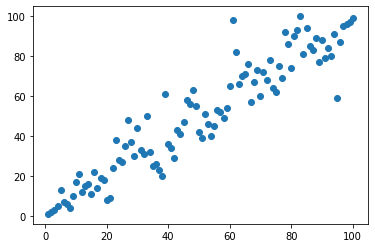

In [19]:
plt.scatter(ranking_db["value ranking"], ranking_db["simple vote rate ranking"])

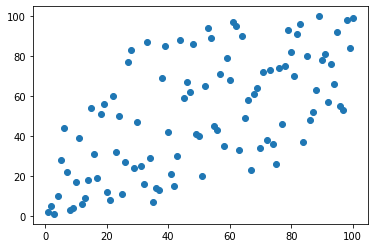

In [20]:
plt.scatter(ranking_db["value ranking"], ranking_db["professional ranking"])

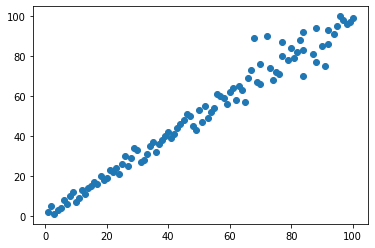

In [21]:
plt.scatter(ranking_db["simple vote ranking"], ranking_db["professional ranking"])

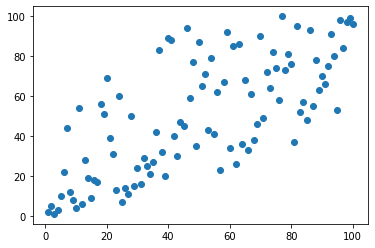

In [22]:
plt.scatter(ranking_db["simple vote rate ranking"], ranking_db["professional ranking"])

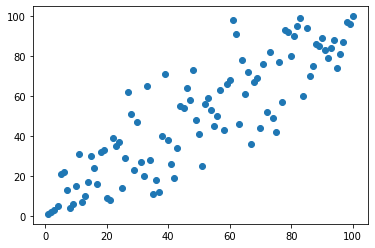

In [23]:
plt.scatter(ranking_db["value ranking"], ranking_db["professional ranking 2"])

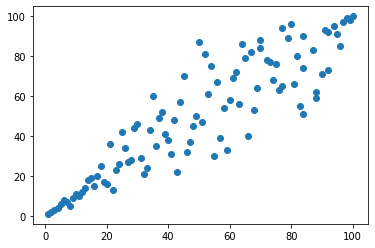

In [24]:
plt.scatter(ranking_db["simple vote ranking"], ranking_db["professional ranking 2"])

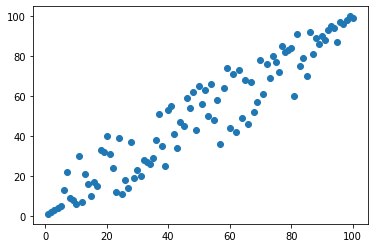

In [25]:
plt.scatter(ranking_db["simple vote rate ranking"], ranking_db["professional ranking 2"])

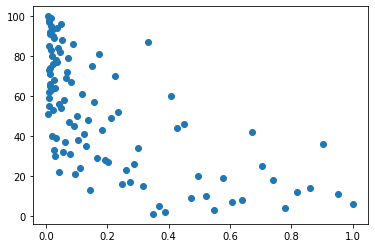

In [26]:
plt.scatter(ranking_db["popularity"], ranking_db["professional ranking 2"])